In [ ]:
%load_ext autoreload
%autoreload 2
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as T

import tensorflow.keras as keras
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

In [2]:
c = Image.open('sample_images/chicago.jpg')
s = Image.open('sample_images/starry.jpg')

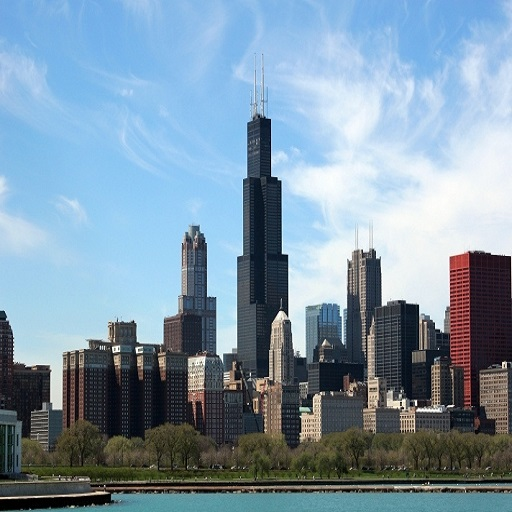

In [3]:
c

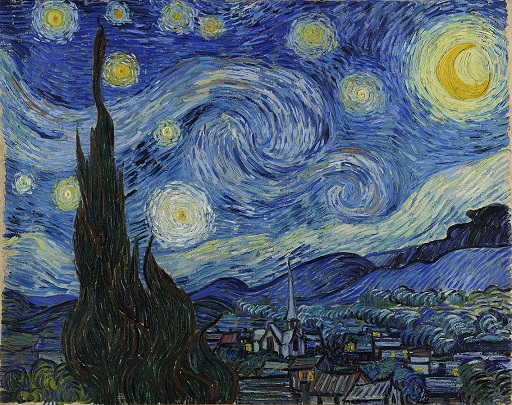

In [4]:
s

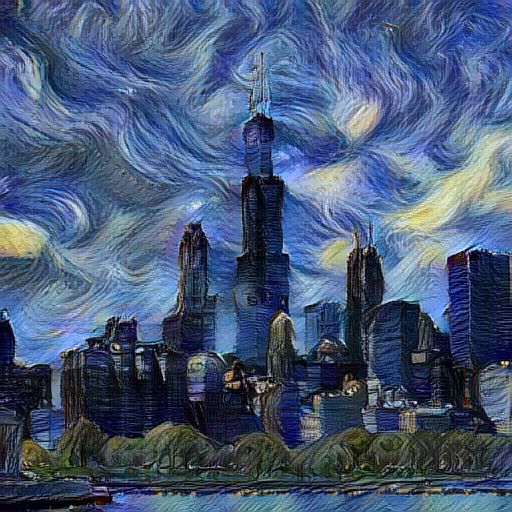

In [5]:
from model.model import Stylizer
net = Stylizer()
net(c,s,1)

In [6]:
net.encoder.state_dict().keys()

odict_keys(['enc_4.0.weight', 'enc_4.0.bias', 'enc_4.2.weight', 'enc_4.2.bias', 'enc_4.5.weight', 'enc_4.5.bias', 'enc_4.9.weight', 'enc_4.9.bias', 'enc_4.12.weight', 'enc_4.12.bias', 'enc_4.16.weight', 'enc_4.16.bias', 'enc_4.19.weight', 'enc_4.19.bias', 'enc_4.22.weight', 'enc_4.22.bias', 'enc_4.25.weight', 'enc_4.25.bias', 'enc_4.29.weight', 'enc_4.29.bias', 'enc_5.1.weight', 'enc_5.1.bias', 'enc_5.4.weight', 'enc_5.4.bias', 'enc_5.7.weight', 'enc_5.7.bias', 'enc_5.11.weight', 'enc_5.11.bias'])

In [7]:
from model.model import Encoder, Decoder, get_transformer

In [8]:
encoder = Encoder().to('cuda')
decoder = Decoder().to('cuda')
trfm = get_transformer().to('cuda')

iters = 1
dummy_content = torch.randn(1, 3, 512, 512, device='cuda')
dummy_style = torch.randn(1, 3, 512,512, device='cuda')

with torch.no_grad():
    c4_1 = dummy_content.detach().clone()
    s4_1 = dummy_style.detach().clone()
    for _ in range(iters):
        out = encoder(c4_1)
        
        torch.onnx.export(encoder, c4_1, 
                          'encoder.onnx',
                          input_names=['image'],
                          output_names=('out4_1','out5_1'),
                          opset_version=11
                         )
        c4_1, c5_1 = out
        s4_1, s5_1 = encoder(s4_1)

        
        c_tfm = trfm(c4_1, s4_1, c5_1, s5_1)
        
        torch.onnx.export(trfm, (c4_1, s4_1, c5_1, s5_1),
                          'transform.onnx',
                          input_names=['c4_1', 's4_1', 'c5_1', 's5_1'],
                          opset_version=11,
                          output_names=('c_tfm',)
                         )
        
        c_stylized = decoder(c_tfm)
        
        torch.onnx.export(decoder, c_tfm,
                         'decoder.onnx',
                          input_names=['c_tfm'],
                          opset_version=11,
                          output_names=('c_stylized',)
                         )
        
        c4_1 = c_stylized.detach().clone()
        s4_1 = dummy_style.detach().clone()

        



# dummy_input = enc_model(dummy_input)

# trf_model = net.transform().cuda()


# dec_model = net.decoder.cuda()
# torch.onnx.export(dec_model,
#                   dummy_input,
#                   'decoder.onnx', 
#                   input_names=['encoded'],
#                  opset_version=11)



In [9]:
pip install onnx-tf

You should consider upgrading via the 'c:\users\tornikeo\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [10]:
import onnxruntime as ort
import onnx

In [11]:
def run_onnx(model_path, **kwargs):
    kwargs = {k:np.array(v) for k,v in kwargs.items()}
    out = ort.InferenceSession(model_path)\
        .run(None,input_feed=kwargs)    
    return out

In [12]:
crop = T.RandomCrop((512,512),pad_if_needed=True,padding_mode='reflect')
resize = T.Resize((512,512))
batch_dim = T.Lambda(lambda x:x[None,...])
to_tensor = T.ToTensor()

content_tfm = T.Compose((resize, to_tensor, batch_dim))
style_tfm = T.Compose((resize, to_tensor, batch_dim))

iters = 2
c_inp =content_tfm(c)
s_inp =style_tfm(s)

with torch.no_grad():
    c4_1 = c_inp.detach().clone()
    s4_1 = s_inp.detach().clone()
    for _ in range(iters):
        c4_1, c5_1 = run_onnx('encoder.onnx', image=c4_1)
        s4_1, s5_1 = run_onnx('encoder.onnx', image=s4_1)
        (c_tfm,) = run_onnx('transform.onnx', c4_1=c4_1,
                         s4_1=s4_1, c5_1=c5_1, s5_1=s5_1)
        (c_stylized,) = run_onnx('decoder.onnx', c_tfm=c_tfm)
        c4_1 = c_stylized#.detach().clone()
        s4_1 = s_inp#.detach().clone()
        c4_1 = c4_1.clip(0,1)

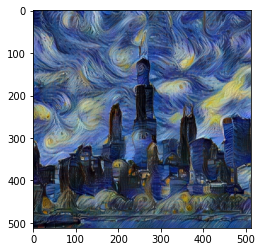

In [13]:
plt.imshow(c4_1.transpose(0,2,3,1)[0])

In [14]:
model_files = ['decoder.onnx','encoder.onnx','transform.onnx']

In [16]:
from pathlib import Path
from onnx_tf.backend import prepare
tf_files = []
for file in model_files:
    print(f'converting {file}')
    onnx_model = onnx.load(file)  # load onnx model
    tf_rep = prepare(onnx_model)  # prepare tf representation
    tf_model_path = f"tf_models/{Path(file).stem}"
    tf_rep.export_graph(tf_model_path)  # export the model
    tf_files.append(tf_model_path)
    # !onnx-tf convert -i {file} -o {Path(file).stem + '.tf2'}

c:\users\tornikeo\appdata\local\programs\python\python39\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.7.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


converting decoder.onnx


INFO:tensorflow:Assets written to: tf_models/decoder\assets


INFO:tensorflow:Assets written to: tf_models/decoder\assets


converting encoder.onnx


INFO:tensorflow:Assets written to: tf_models/encoder\assets


INFO:tensorflow:Assets written to: tf_models/encoder\assets


converting transform.onnx


INFO:tensorflow:Assets written to: tf_models/transform\assets


INFO:tensorflow:Assets written to: tf_models/transform\assets


In [17]:
pip install tensorflowjs[wizard]

  Using cached PyInquirer-1.0.3-py3-none-any.whl
  Using cached prompt_toolkit-1.0.14-py3-none-any.whl (248 kB)
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 3.0.26
    Uninstalling prompt-toolkit-3.0.26:
      Successfully uninstalled prompt-toolkit-3.0.26
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 6.4.0 requires prompt-toolkit!=3.0.0,!=3.0.1,<3.1.0,>=2.0.0, but you have prompt-toolkit 1.0.14 which is incompatible.
ipython 8.0.1 requires prompt-toolkit!=3.0.0,!=3.0.1,<3.1.0,>=2.0.0, but you have prompt-toolkit 1.0.14 which is incompatible.
You should consider upgrading via the 'c:\users\tornikeo\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [ ]:
for tf_file in tf_files:
    js_file = f'js_models/{Path(tf_file).stem}'
    !tensorflowjs_converter \
        --input_format=tf_saved_model \
        --output_format=tfjs_graph_model \
        {tf_file} \
        {js_file}
        

[autoreload of prompt_toolkit.cache failed: Traceback (most recent call last):
  File "c:\users\tornikeo\appdata\local\programs\python\python39\lib\site-packages\IPython\extensions\autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "c:\users\tornikeo\appdata\local\programs\python\python39\lib\site-packages\IPython\extensions\autoreload.py", line 480, in superreload
    update_generic(old_obj, new_obj)
  File "c:\users\tornikeo\appdata\local\programs\python\python39\lib\site-packages\IPython\extensions\autoreload.py", line 377, in update_generic
    update(a, b)
  File "c:\users\tornikeo\appdata\local\programs\python\python39\lib\site-packages\IPython\extensions\autoreload.py", line 345, in update_class
    update_instances(old, new)
  File "c:\users\tornikeo\appdata\local\programs\python\python39\lib\site-packages\IPython\extensions\autoreload.py", line 303, in update_instances
    ref.__class__ = new
TypeError: __class__ assignment: 'SimpleCache' ob

Writing weight file js_models/decoder\model.json...
weight PartitionedCall/onnx_tf_prefix_Concat_1 with shape (8,) and dtype int64 was auto converted to the type int32
weight PartitionedCall/onnx_tf_prefix_Constant_2 with shape (2,) and dtype int64 was auto converted to the type int32
weight PartitionedCall/Where with shape (0, 1) and dtype int64 was auto converted to the type int32
weight PartitionedCall/Cast with shape (1,) and dtype int64 was auto converted to the type int32
weight PartitionedCall/GatherV2 with shape (0,) and dtype int64 was auto converted to the type int32
weight PartitionedCall/zeros with shape () and dtype int64 was auto converted to the type int32
weight PartitionedCall/SelectV2_1 with shape (1,) and dtype int64 was auto converted to the type int32
weight PartitionedCall/zeros_1 with shape () and dtype int64 was auto converted to the type int32
weight PartitionedCall/Const_2 with shape () and dtype int64 was auto converted to the type int32
weight PartitionedCal